In [4]:
import os
import cv2
import shutil
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
from PIL import Image


## Function for Image visualizing ##

In [27]:
# ----------------------------
# 1. Load Models and Define Transform
# ----------------------------

def show_predicted_image(YOLO_MODEL_PATH,CLF_MODEL_PATH, image_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    det_model = YOLO(YOLO_MODEL_PATH)
    
    
    def load_resnet50():
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 2) 
        return model.to(device)
    
    
    clf_model = load_resnet50()
    clf_model.load_state_dict(torch.load(CLF_MODEL_PATH, map_location=device))
    clf_model.eval()
    
    
    clf_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    # ----------------------------
    # 2. Process a Single Image
    # ----------------------------
    
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found at path: {image_path}")
    orig_image = image.copy()  
    img_h, img_w = image.shape[:2]
    
    
    results = det_model(image)
    
    MIN_AREA_RATIO = 0.00
    
    
    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy() 
        scores = result.boxes.conf.cpu().numpy()  
        
        for box, score in zip(boxes, scores):
            x1, y1, x2, y2 = box.astype(int)
            box_area = (x2 - x1) * (y2 - y1)
            if box_area < MIN_AREA_RATIO * (img_w * img_h):
                continue
            crop = orig_image[y1:y2, x1:x2]
            if crop.size == 0:
                continue
    
            crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
            crop_pil = Image.fromarray(crop_rgb)
            input_tensor = clf_transform(crop_pil).unsqueeze(0).to(device)
    
            with torch.no_grad():
                outputs = clf_model(input_tensor)  
                pred_class = int(torch.argmax(outputs, dim=1).item())
    
            color = (0, 0, 255) if pred_class == 0 else (0, 255, 0) 
            label_text = 'weed' if pred_class == 0 else 'crop'
    
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            cv2.putText(image, f'{label_text}:{score:.2f}', (x1, max(y1 - 10, 10)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    # ----------------------------
    # 3. Visualize & Save Results
    # ----------------------------
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    
    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title("Detection + Classification")
    plt.show()
    
    output_path = 'single_image_result.jpg'
    cv2.imwrite(output_path, image)
    print(f"Annotated image saved at {output_path}")


### Define model paths ###

In [28]:
YOLO_MODEL_PATH = r'/kaggle/input/yolo/pytorch/default/3/best (3).pt'
CLF_MODEL_PATH  = r'/kaggle/input/yolo/pytorch/default/3/best_model (4).pth'

## SOME IMAGES ##


0: 640x640 1 weed, 16.2ms
Speed: 2.6ms preprocess, 16.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


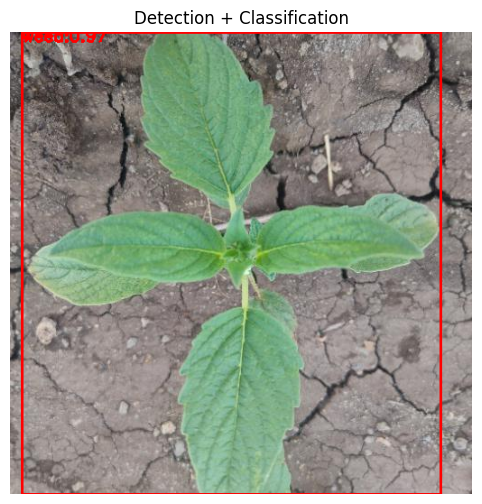

Annotated image saved at single_image_result.jpg


In [29]:
image_path = '/kaggle/input/weedzip/test/images/agri_0_9488_jpeg.rf.9032dd69a6977c2d34b8d67d9da0fe34.jpg'
show_predicted_image(YOLO_MODEL_PATH,CLF_MODEL_PATH, image_path)


0: 640x640 2 backgrounds, 16.2ms
Speed: 2.3ms preprocess, 16.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


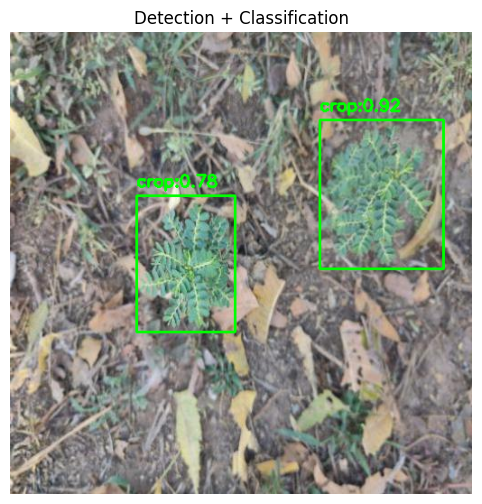

Annotated image saved at single_image_result.jpg


In [30]:
image_path = '/kaggle/input/weedzip/test/images/agri_0_9135_jpeg.rf.f5afbc71d5606255b3522bfc6feec990.jpg'
show_predicted_image(YOLO_MODEL_PATH,CLF_MODEL_PATH, image_path)


0: 640x640 5 backgrounds, 16.2ms
Speed: 2.3ms preprocess, 16.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


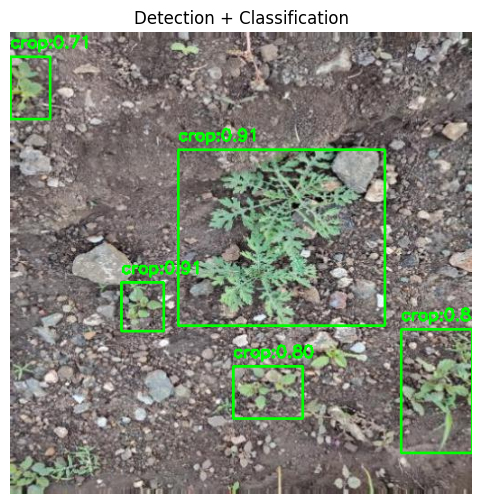

Annotated image saved at single_image_result.jpg


In [31]:
image_path = '/kaggle/input/weedzip/test/images/agri_0_9116_jpeg.rf.812b125d18a8e7b60a363dc022354c92.jpg'
show_predicted_image(YOLO_MODEL_PATH,CLF_MODEL_PATH, image_path)


0: 640x640 1 weed, 16.2ms
Speed: 2.3ms preprocess, 16.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


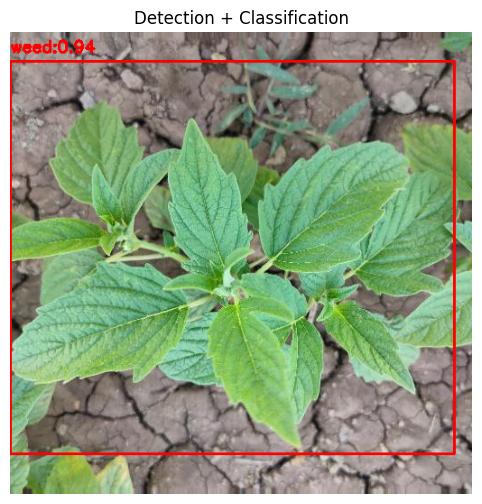

Annotated image saved at single_image_result.jpg


In [32]:
image_path = '/kaggle/input/weedzip/test/images/agri_0_9601_jpeg.rf.98980a58475f9ab84aec08679905defb.jpg'
show_predicted_image(YOLO_MODEL_PATH,CLF_MODEL_PATH, image_path)


0: 640x640 2 weeds, 16.3ms
Speed: 2.5ms preprocess, 16.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


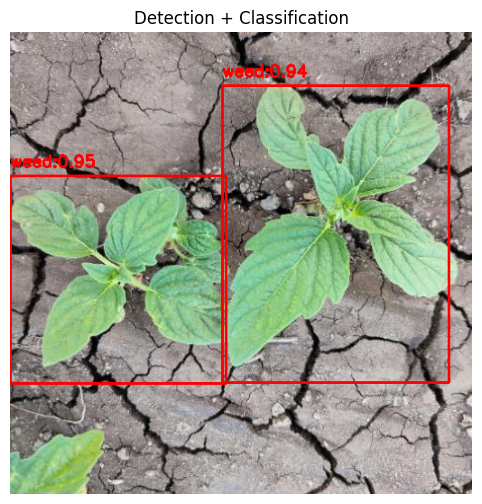

Annotated image saved at single_image_result.jpg


In [33]:
image_path = '/kaggle/input/weedzip/test/images/agri_0_9424_jpeg.rf.f758222e980e6d4265312a3cf6ac6751.jpg'
show_predicted_image(YOLO_MODEL_PATH,CLF_MODEL_PATH, image_path)